# CFReT-Screen analysis

In this notebook, we will be applying `buscar` to the CFReT initial screen.

The resource for this dataset can be found [here](https://github.com/WayScience/targeted_fibrosis_drug_screen/tree/main/3.preprocessing_features)


In [1]:
import sys
import json
import pathlib

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../")
from utils.io_utils import load_profiles

# from utils.metrics import measure_phenotypic_activity
from utils.preprocess import apply_pca
from utils.data_utils import split_meta_and_features
from utils.signatures import get_signatures
from utils.heterogeneity import optimized_clustering
from utils.metrics import measure_phenotypic_activity
from utils.identify_hits import identify_compound_hit

/home/erikserrano/Software/miniconda3/envs/buscar/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Parameters

Below are the parameters used for this notebook. The CFReT-screen dataset contains two hearts: **Healthy (Heart 7)** and **Failing (Heart 19)**, which has been diagnosed with dilated cardiomyopathy.

DMSO Control Naming Convention

To distinguish between control conditions from different heart sources, the `Metadata_treatment` column values are modified as follows:
- **Healthy controls** (Heart 7 + DMSO): `"DMSO_heart_7"`
- **Failing controls** (Heart 19 + DMSO): `"DMSO_heart_19"`

Parameter Definitions:
- **`healthy_ref_treatment`**: Reference treatment name for healthy controls
- **`failing_ref_treatment`**: Reference treatment name for failing heart controls  
- **`treatment_col`**: Column name containing treatment metadata
- **`cfret_screen_cluster_param_grid`**: Dictionary defining the hyperparameter search space for clustering optimization when assessing heterogeneity across treatments. Includes:
    - `cluster_resolution`: Granularity of clusters (float, 0.1–2.2)
    - `n_neighbors`: Number of neighbors for graph construction (int, 5–100)
    - `cluster_method`: Clustering algorithm (categorical: leiden)
    - `neighbor_distance_metric`: Distance metric for neighbor computation (categorical: euclidean, cosine, manhattan)

In [2]:
# setting parameters
healthy_ref_treatment = "DMSO_heart_7"
failing_ref_treatment = "DMSO_heart_19"
treatment_col = "Metadata_treatment"

# parameters used for clustering optimization
cfret_screen_cluster_param_grid = {
    # Clustering resolution: how granular the clusters should be
    "cluster_resolution": {"type": "float", "low": 0.1, "high": 2.2},
    # Number of neighbors for graph construction
    "n_neighbors": {"type": "int", "low": 5, "high": 100},
    # Clustering algorithm
    "cluster_method": {"type": "categorical", "choices": ["leiden"]},
    # Distance metric for neighbor computation
    "neighbor_distance_metric": {
        "type": "categorical",
        "choices": ["euclidean", "cosine", "manhattan"],
    },
}

setting paths

In [3]:
# load in raw data from
cfret_data_dir = pathlib.Path(
    "../0.download-data/data/sc-profiles/cfret-screen"
).resolve(strict=True)
cfret_profiles_path = (cfret_data_dir / "cfret_screen_concat_profiles.parquet").resolve(
    strict=True
)

# make results dir
results_dir = pathlib.Path("./results/cfret-screen").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# loading profiles
cfret_screen_df = load_profiles(cfret_profiles_path)
cfret_screen_meta, cfret_screen_feats = split_meta_and_features(cfret_screen_df)

# updating the treatment name to reflect the heart source for DMSO in healthy cells
# this is our reference for healthy cells when measuring phenotypic activity
cfret_screen_df = cfret_screen_df.with_columns(
    pl.when(
        (pl.col("Metadata_treatment") == "DMSO")
        & (pl.col("Metadata_cell_type") == "healthy")
    )
    .then(pl.lit("DMSO_heart_7"))
    .otherwise(pl.col("Metadata_treatment"))
    .alias("Metadata_treatment")
)
cfret_screen_df = cfret_screen_df.with_columns(
    pl.when(
        (pl.col("Metadata_treatment") == "DMSO")
        & (pl.col("Metadata_cell_type") == "failing")
    )
    .then(pl.lit("DMSO_heart_19"))
    .otherwise(pl.col("Metadata_treatment"))
    .alias("Metadata_treatment")
)

# Generate feature value shuffled dataframe for control
shuffled_cfret_screen_df = cfret_screen_feats.select(
    [pl.col(col).shuffle() for col in cfret_screen_feats.columns]
)

# Display data
cfret_screen_df.head()

Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,Metadata_cell_id,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_Zernike_4_0,Cytoplasm_AreaShape_Zernike_5_1,Cytoplasm_AreaShape_Zernike_6_0,Cytoplasm_AreaShape_Zernike_6_2,Cytoplasm_AreaShape_Zernike_7_1,Cytoplasm_AreaShape_Zernike_7_3,Cytoplasm_AreaShape_Zernike_8_0,Cytoplasm_AreaShape_Zernike_8_2,Cytoplasm_AreaShape_Zernike_9_1,Cytoplasm_AreaShape_Zernike_9_3,Cytoplasm_AreaShape_Zernike_9_5,Cytoplasm_AreaShape_Zernike_9_7,Cytoplasm_Correlation_Correlation_ER_Hoechst,Cytoplasm_Correlation_Correlation_ER_PM,…,Nuclei_Texture_Correlation_ER_3_02_256,Nuclei_Texture_Correlation_ER_3_03_256,Nuclei_Texture_Correlation_Hoechst_3_00_256,Nuclei_Texture_Correlation_Hoechst_3_01_256,Nuclei_Texture_Correlation_Hoechst_3_02_256,Nuclei_Texture_Correlation_Hoechst_3_03_256,Nuclei_Texture_Correlation_Mitochondria_3_00_256,Nuclei_Texture_Correlation_Mitochondria_3_01_256,Nuclei_Texture_Correlation_Mitochondria_3_02_256,Nuclei_Texture_Correlation_Mitochondria_3_03_256,Nuclei_Texture_Correlation_PM_3_00_256,Nuclei_Texture_Correlation_PM_3_01_256,Nuclei_Texture_Correlation_PM_3_02_256,Nuclei_Texture_Correlation_PM_3_03_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_00_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_01_256,Nuclei_Texture_InfoMeas1_ER_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_PM_3_00_256,Nuclei_Texture_InfoMeas1_PM_3_01_256,Nuclei_Texture_InfoMeas1_PM_3_02_256,Nuclei_Texture_InfoMeas1_PM_3_03_256,Nuclei_Texture_InfoMeas2_PM_3_00_256,Nuclei_Texture_InfoMeas2_PM_3_01_256,Nuclei_Texture_InfoMeas2_PM_3_02_256,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256
str,i64,i64,str,str,str,str,f64,f64,f64,f64,i64,i64,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,870.048176,222.975912,883.760337,261.61621,8,2,"""localhost240927060001""","""B02""",1,1,3,3,"""f07""","""12575616795011807720""",-0.751363,0.572923,-0.397076,0.280466,-0.842051,0.921933,-0.808205,-0.152162,-0.576562,1.018035,-0.555971,1.136591,-1.010685,-0.580809,0.296295,0.374481,…,1.26599,0.223125,0.001392,0.481817,0.776713,-0.060115,-0.47829,0.369701,0.664598,-0.595822,-0.779385,-1.10438,0.019679,-0.081576,0.899131,0.131613,0.288529,-0.396068,-1.475314,0.104475,0.605291,0.480656,-0.418191,0.05484,-0.245545,-0.194699,0.449148,0.153167,-1.314356,-0.527268,-0.28336,-0.966427,-0.028467,0.025132,0.531559,0.161083,-0.084311
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,372.665138,78.150612,422.940605,121.357251,9,3,"""localhost240927060001""","""B02""",1,1,3,3,"""f08""","""3793444334871218055""",-1.315906,1.653718,-0.660428,-1.684414,-0.408983,-0.805361,-1.386725,-1.901982,-0.170266,-0.830062,-1.194093,-1.405091,-1.373065,-1.294781,0.279446,0.891917,…,1.10232

In [5]:
print(
    f"number of healthy cells {cfret_screen_df.filter(pl.col('Metadata_treatment') == 'DMSO_heart_7').height}"
)
print(
    f"number of failing cells {cfret_screen_df.filter(pl.col('Metadata_treatment') == 'DMSO_heart_19').height}"
)

number of healthy cells 1720
number of failing cells 4915


## Preprocessing

Filtering Treatments with Low Cell Counts:

Treatments with low cell counts were removed from the analysis. This reduction in cell numbers is typically caused by cellular toxicity, which leads to cell death and consequently results in insufficient cell representation for downstream analysis.

Low cell count treatments also pose challenges when assessing heterogeneity, as there are not enough data points to form meaningful clusters. To address this, highly toxic compounds with very few surviving cells were excluded from the BUSCAR analysis.

A threshold of 10% was applied based on Scanpy documentation, which recommends having at least 15–100 data points to compute a reliable neighborhood graph. To validate this threshold, we generated a histogram of cell counts and marked the 10th percentile with a red line. Treatments falling below this threshold were removed and excluded from the BUSCAR pipeline.

In [6]:
# count number of cells per Metadata_treatment and ensure 'count' is Int64
counts = cfret_screen_df["Metadata_treatment"].value_counts()
counts = counts.with_columns(pl.col("count").cast(pl.Int64))
counts = counts.sort("count", descending=True)
counts = counts.to_pandas()

In [7]:
# using numpy to calculate 10th percentile
tenth_percentile = np.round(np.percentile(counts["count"], 10), 3)
print(f"10th percentile of cell counts: {tenth_percentile} cells")

10th percentile of cell counts: 23.3 cells


Plotting cell count distribution

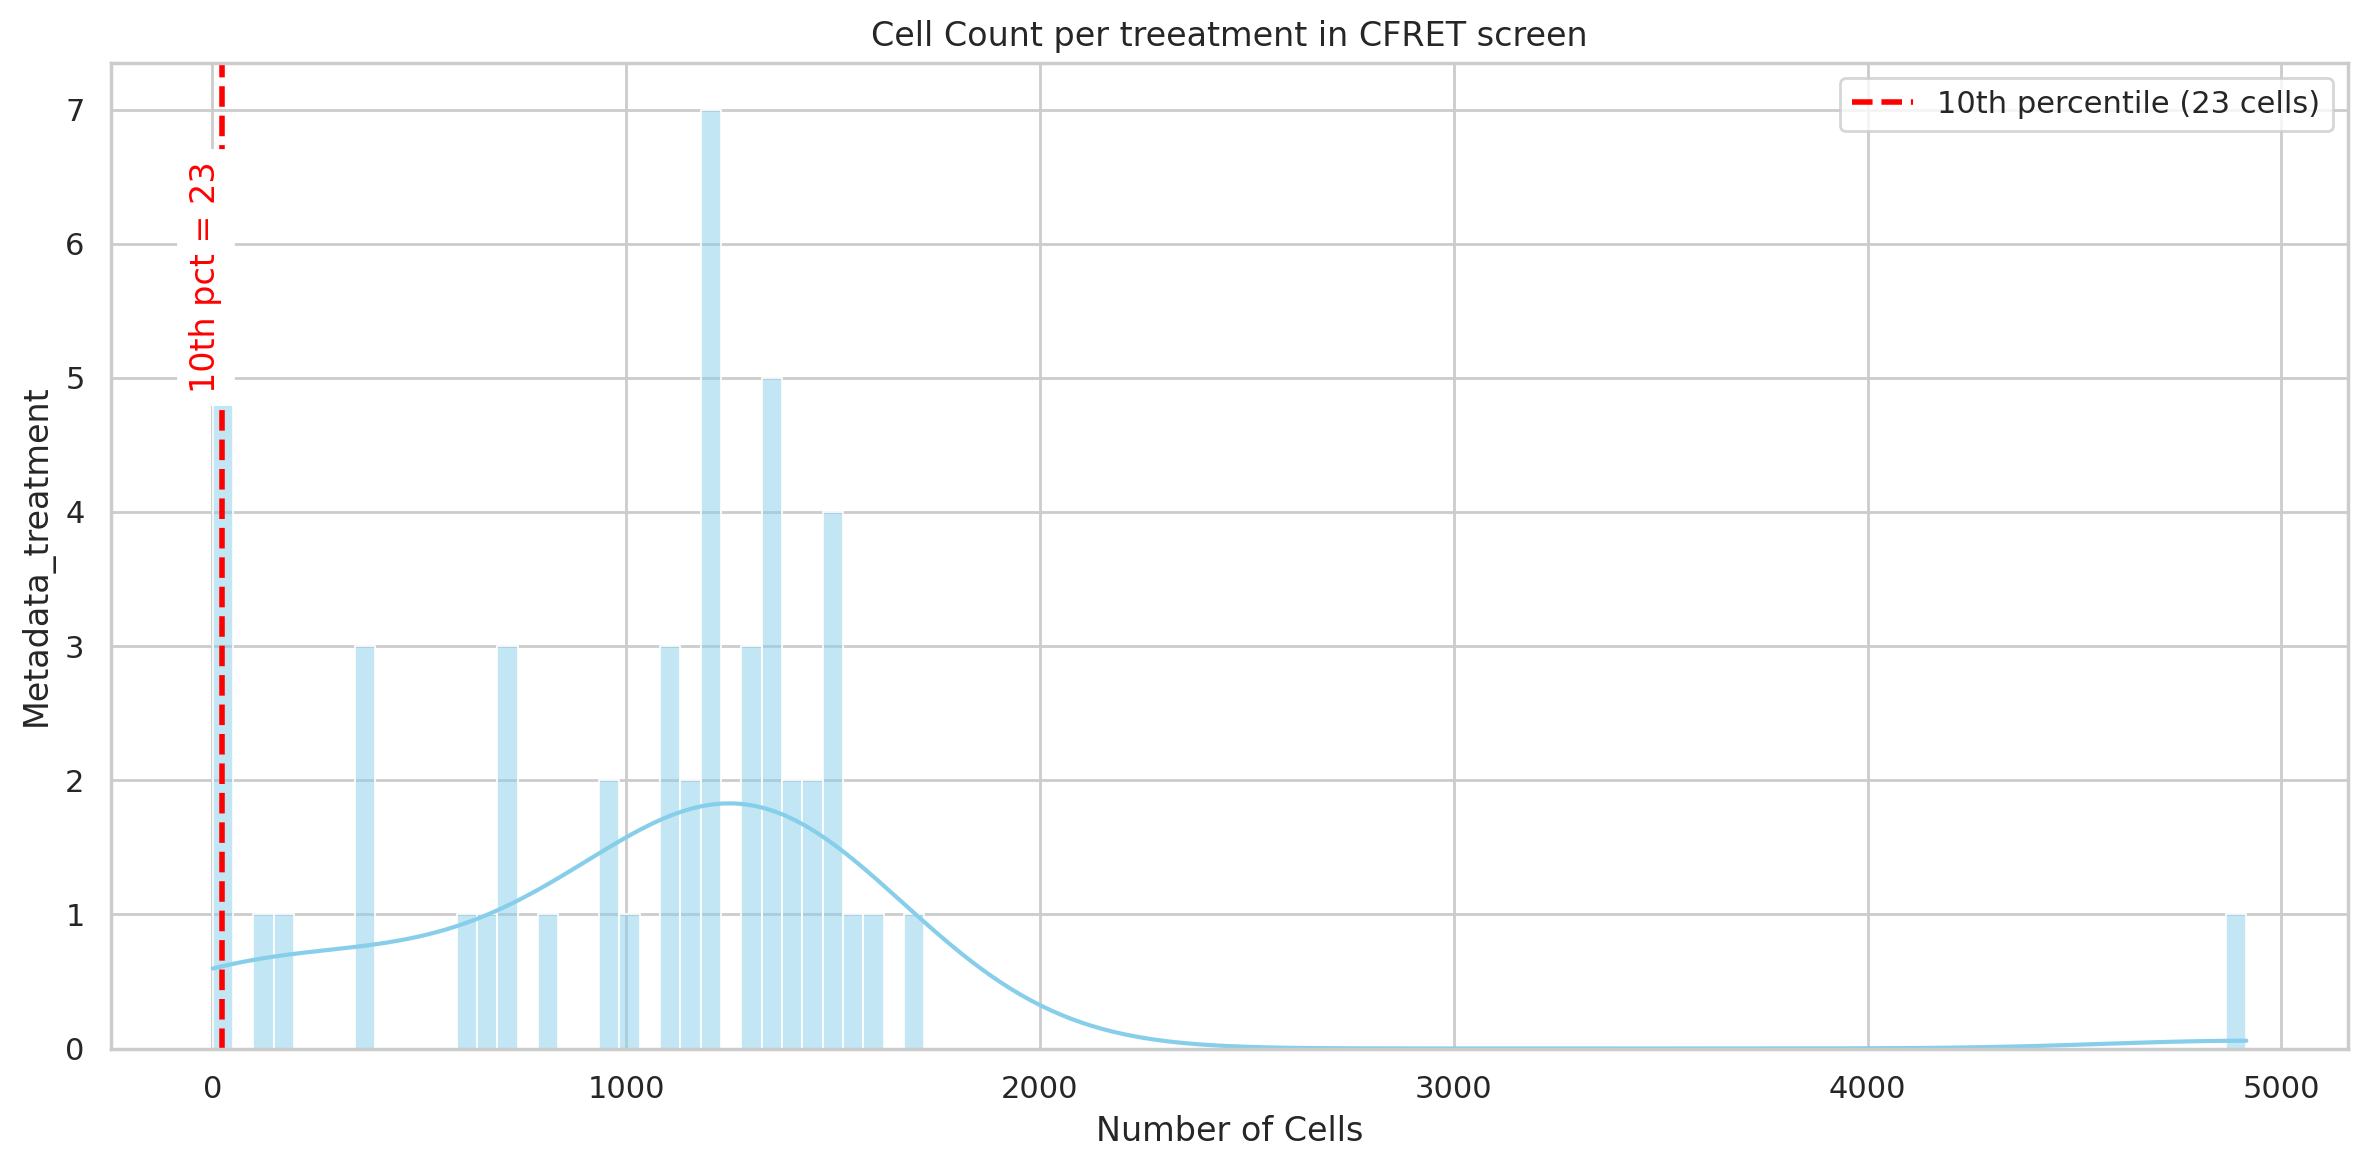

In [8]:
# setting seaborn style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=200)

# plot histogram with seaborn
ax = sns.histplot(data=counts, x="count", bins=100, color="skyblue", kde=True)

# add 10th percentile vertical line and annotation (tenth_percentile already defined)
ax.axvline(
    x=tenth_percentile,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"10th percentile ({int(tenth_percentile)} cells)",
)
ymin, ymax = ax.get_ylim()
ax.text(
    tenth_percentile,
    ymax * 0.9,
    f"10th pct = {tenth_percentile:.0f}",
    color="red",
    rotation=90,
    va="top",
    ha="right",
    backgroundcolor="white",
)

# labeling the plot
ax.set_xlabel("Number of Cells")
ax.set_ylabel("Metadata_treatment")
ax.set_title("Cell Count per treeatment in CFRET screen")

# adding legend
ax.legend()

# adjust layout
plt.tight_layout()

# save the plot
plt.savefig(results_dir / "cell_count_per_treatment_cfret_screen.png", dpi=500)

# display plot
plt.show()

Removing cells under those specific treatments

In [9]:
# remove treatments with cell counts below the 10th percentile
kept_treatments = counts[counts["count"] >= tenth_percentile][
    "Metadata_treatment"
].tolist()
cfret_screen_df = cfret_screen_df.filter(
    pl.col("Metadata_treatment").is_in(kept_treatments)
)

# print the treatments that were removed
removed_treatments = counts[counts["count"] < tenth_percentile][
    "Metadata_treatment"
].tolist()
print(
    "Removed treatments due to low cell counts (below 10th percentile):",
    removed_treatments,
)

cfret_screen_df.head()

Removed treatments due to low cell counts (below 10th percentile): ['UCD-0159290', 'UCD-0001783', 'UCD-0159264', 'UCD-0018091', 'UCD-0001792', 'UCD-0000721']


Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,Metadata_cell_id,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_Zernike_4_0,Cytoplasm_AreaShape_Zernike_5_1,Cytoplasm_AreaShape_Zernike_6_0,Cytoplasm_AreaShape_Zernike_6_2,Cytoplasm_AreaShape_Zernike_7_1,Cytoplasm_AreaShape_Zernike_7_3,Cytoplasm_AreaShape_Zernike_8_0,Cytoplasm_AreaShape_Zernike_8_2,Cytoplasm_AreaShape_Zernike_9_1,Cytoplasm_AreaShape_Zernike_9_3,Cytoplasm_AreaShape_Zernike_9_5,Cytoplasm_AreaShape_Zernike_9_7,Cytoplasm_Correlation_Correlation_ER_Hoechst,Cytoplasm_Correlation_Correlation_ER_PM,…,Nuclei_Texture_Correlation_ER_3_02_256,Nuclei_Texture_Correlation_ER_3_03_256,Nuclei_Texture_Correlation_Hoechst_3_00_256,Nuclei_Texture_Correlation_Hoechst_3_01_256,Nuclei_Texture_Correlation_Hoechst_3_02_256,Nuclei_Texture_Correlation_Hoechst_3_03_256,Nuclei_Texture_Correlation_Mitochondria_3_00_256,Nuclei_Texture_Correlation_Mitochondria_3_01_256,Nuclei_Texture_Correlation_Mitochondria_3_02_256,Nuclei_Texture_Correlation_Mitochondria_3_03_256,Nuclei_Texture_Correlation_PM_3_00_256,Nuclei_Texture_Correlation_PM_3_01_256,Nuclei_Texture_Correlation_PM_3_02_256,Nuclei_Texture_Correlation_PM_3_03_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_00_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_01_256,Nuclei_Texture_InfoMeas1_ER_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_PM_3_00_256,Nuclei_Texture_InfoMeas1_PM_3_01_256,Nuclei_Texture_InfoMeas1_PM_3_02_256,Nuclei_Texture_InfoMeas1_PM_3_03_256,Nuclei_Texture_InfoMeas2_PM_3_00_256,Nuclei_Texture_InfoMeas2_PM_3_01_256,Nuclei_Texture_InfoMeas2_PM_3_02_256,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256
str,i64,i64,str,str,str,str,f64,f64,f64,f64,i64,i64,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,870.048176,222.975912,883.760337,261.61621,8,2,"""localhost240927060001""","""B02""",1,1,3,3,"""f07""","""12575616795011807720""",-0.751363,0.572923,-0.397076,0.280466,-0.842051,0.921933,-0.808205,-0.152162,-0.576562,1.018035,-0.555971,1.136591,-1.010685,-0.580809,0.296295,0.374481,…,1.26599,0.223125,0.001392,0.481817,0.776713,-0.060115,-0.47829,0.369701,0.664598,-0.595822,-0.779385,-1.10438,0.019679,-0.081576,0.899131,0.131613,0.288529,-0.396068,-1.475314,0.104475,0.605291,0.480656,-0.418191,0.05484,-0.245545,-0.194699,0.449148,0.153167,-1.314356,-0.527268,-0.28336,-0.966427,-0.028467,0.025132,0.531559,0.161083,-0.084311
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,372.665138,78.150612,422.940605,121.357251,9,3,"""localhost240927060001""","""B02""",1,1,3,3,"""f08""","""3793444334871218055""",-1.315906,1.653718,-0.660428,-1.684414,-0.408983,-0.805361,-1.386725,-1.901982,-0.170266,-0.830062,-1.194093,-1.405091,-1.373065,-1.294781,0.279446,0.891917,…,1.10232

## Buscar pipeline

Get on and off signatures

In [10]:
# once the data is loaded, separate the controls
# here we want the healthy DMSO cells to be the target since the screen consists
# of failing cells treated with compounds
healthy_ref_df = cfret_screen_df.filter(pl.col("Metadata_treatment") == "DMSO_heart_7")
failing_ref_df = cfret_screen_df.filter(pl.col("Metadata_treatment") == "DMSO_heart_19")

# creating signatures
on_sigs, off_sigs, _ = get_signatures(
    ref_profiles=healthy_ref_df,
    exp_profiles=failing_ref_df,
    morph_feats=cfret_screen_feats,
    test_method="mann_whitney_u",
)

print("length of on and off signatures:", len(on_sigs), len(off_sigs))

# save signatures
signatures_dir = results_dir / "CFRet-screen-signatures.json"
with open(signatures_dir, "w") as sig_file:
    json.dump(
        {"on_signatures": on_sigs, "off_signatures": off_sigs}, sig_file, indent=4
    )

length of on and off signatures: 405 69


Assess heterogeneity

In [11]:
# Convert raw feature space to PCA space that explains 95% of variance
cfret_screen_pca_df = apply_pca(
    profiles=cfret_screen_df,
    meta_features=cfret_screen_meta,
    morph_features=cfret_screen_feats,
    var_explained=0.95,
)

# split meta and features again after PCA
cfret_screen_pca_feats = cfret_screen_pca_df.drop(cfret_screen_meta).columns

In [ ]:
# setting best params outputs
cfret_screen_treatment_best_params_outpath = (
    results_dir / "cfret_screen_treatment_clustering_params.json"
).resolve()
cfret_screen_treatment_cluster_df_outpath = (
    results_dir / "cfret_screen_treatment_clustered.parquet"
).resolve()

# here we are clustering each treatment-heart combination
# this will allow us to see how each heart responds to each treatment
cfret_screen_treatment_clustered_df, cfret_screen_treatment_clustered_best_params = (
    optimized_clustering(
        profiles=cfret_screen_df,
        meta_features=cfret_screen_meta,
        morph_features=cfret_screen_feats,
        treatment_col="Metadata_treatment",
        param_grid=cfret_screen_cluster_param_grid,
        n_trials=500,
        n_jobs=-22,
        study_name="CFReT_screen_clustering",
    )
)

# save best params as json and dataframe as parquet
cfret_screen_treatment_clustered_df.write_parquet(
    cfret_screen_treatment_cluster_df_outpath
)
with open(cfret_screen_treatment_best_params_outpath, "w") as f:
    json.dump(
        cfret_screen_treatment_clustered_best_params,
        f,
        indent=4,
    )

Optimizing clustering for 46 treatment(s) with 30 job(s)...


/home/erikserrano/Software/miniconda3/envs/buscar/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/erikserrano/Software/miniconda3/envs/buscar/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/erikserrano/Software/miniconda3/envs/buscar/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptool

  DMSO_heart_7: silhouette=0.000, params={'cluster_resolution': 0.9897732067437842, 'n_neighbors': 53, 'cluster_method': 'leiden', 'neighbor_distance_metric': 'cosine'}
  UCD-0159256: silhouette=-0.003, params={'cluster_resolution': 1.7353083701371663, 'n_neighbors': 9, 'cluster_method': 'leiden', 'neighbor_distance_metric': 'euclidean'}
  UCD-0001766: silhouette=0.023, params={'cluster_resolution': 0.7872371778541689, 'n_neighbors': 45, 'cluster_method': 'leiden', 'neighbor_distance_metric': 'manhattan'}
  UCD-0159262: silhouette=0.106, params={'cluster_resolution': 0.4709986051914493, 'n_neighbors': 95, 'cluster_method': 'leiden', 'neighbor_distance_metric': 'manhattan'}
  UCD-0001915: silhouette=0.051, params={'cluster_resolution': 0.5782847549480996, 'n_neighbors': 25, 'cluster_method': 'leiden', 'neighbor_distance_metric': 'manhattan'}
  UCD-0159279: silhouette=0.044, params={'cluster_resolution': 0.46639823003811576, 'n_neighbors': 70, 'cluster_method': 'leiden', 'neighbor_distan

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [13]:
# now merge the cluster labels back to the main dataframe
cfret_screen_df = cfret_screen_df.join(
    cfret_screen_treatment_clustered_df, on="Metadata_cell_id", how="left"
)
cfret_screen_df.head()

Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,Metadata_cell_id,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_Zernike_4_0,Cytoplasm_AreaShape_Zernike_5_1,Cytoplasm_AreaShape_Zernike_6_0,Cytoplasm_AreaShape_Zernike_6_2,Cytoplasm_AreaShape_Zernike_7_1,Cytoplasm_AreaShape_Zernike_7_3,Cytoplasm_AreaShape_Zernike_8_0,Cytoplasm_AreaShape_Zernike_8_2,Cytoplasm_AreaShape_Zernike_9_1,Cytoplasm_AreaShape_Zernike_9_3,Cytoplasm_AreaShape_Zernike_9_5,Cytoplasm_AreaShape_Zernike_9_7,Cytoplasm_Correlation_Correlation_ER_Hoechst,Cytoplasm_Correlation_Correlation_ER_PM,…,Nuclei_Texture_Correlation_Hoechst_3_02_256,Nuclei_Texture_Correlation_Hoechst_3_03_256,Nuclei_Texture_Correlation_Mitochondria_3_00_256,Nuclei_Texture_Correlation_Mitochondria_3_01_256,Nuclei_Texture_Correlation_Mitochondria_3_02_256,Nuclei_Texture_Correlation_Mitochondria_3_03_256,Nuclei_Texture_Correlation_PM_3_00_256,Nuclei_Texture_Correlation_PM_3_01_256,Nuclei_Texture_Correlation_PM_3_02_256,Nuclei_Texture_Correlation_PM_3_03_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_00_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_01_256,Nuclei_Texture_InfoMeas1_ER_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_PM_3_00_256,Nuclei_Texture_InfoMeas1_PM_3_01_256,Nuclei_Texture_InfoMeas1_PM_3_02_256,Nuclei_Texture_InfoMeas1_PM_3_03_256,Nuclei_Texture_InfoMeas2_PM_3_00_256,Nuclei_Texture_InfoMeas2_PM_3_01_256,Nuclei_Texture_InfoMeas2_PM_3_02_256,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256,Metadata_cluster_id,Metadata_cluster_n_cells,Metadata_treatment_n_cells,Metadata_cluster_ratio
str,i64,i64,str,str,str,str,f64,f64,f64,f64,i64,i64,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,u32,u32,f64
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,870.048176,222.975912,883.760337,261.61621,8,2,"""localhost240927060001""","""B02""",1,1,3,3,"""f07""","""12575616795011807720""",-0.751363,0.572923,-0.397076,0.280466,-0.842051,0.921933,-0.808205,-0.152162,-0.576562,1.018035,-0.555971,1.136591,-1.010685,-0.580809,0.296295,0.374481,…,0.776713,-0.060115,-0.47829,0.369701,0.664598,-0.595822,-0.779385,-1.10438,0.019679,-0.081576,0.899131,0.131613,0.288529,-0.396068,-1.475314,0.104475,0.605291,0.480656,-0.418191,0.05484,-0.245545,-0.194699,0.449148,0.153167,-1.314356,-0.527268,-0.28336,-0.966427,-0.028467,0.025132,0.531559,0.161083,-0.084311,"""DMSO_heart_7_leiden_0""",365,1720,0.212209
"""B""",2,7,"""healthy""",null,"""DMSO_heart_7""",null,372.665138,78.150612,422.940605,121.357251,9,3,"""localhost240927060001""","""B02""",1,1,3,3,"""f08""","""3793444334871218055""",-1.315906,1.653718,-0.660428,-1.684414,-0.408983,-0.805361,-1.386725,-1.901982,-0.170266,-0.830062,-1.194093,-1.405091,-1.373065,-1.294781,0.279446,0.891917,…,0.260714,-0.725359,0.799276,1.3109,0.532934,0.074106,0.416485,1.003

In [14]:
treatment_phenotypic_dist_scores = measure_phenotypic_activity(
    profiles=cfret_screen_df,
    on_signature=on_sigs,
    off_signature=off_sigs,
    ref_treatment="DMSO_heart_7",
    cluster_col="Metadata_cluster_id",
    treatment_col=treatment_col,
)

# save those as csv files
treatment_phenotypic_dist_scores.write_csv(
    results_dir / "cfret_screen_treatment_phenotypic_dist_scores.csv"
)

In [15]:
treatment_rankings = identify_compound_hit(
    distance_df=treatment_phenotypic_dist_scores, method="weighted_sum"
)

# save as csv files
treatment_rankings.write_csv(results_dir / "cfret_screen_treatment_rankings.csv")

In [16]:
treatment_phenotypic_dist_scores

ref_cluster,treatment,trt_cluster,on_dist,off_dist,exp_cluster_ratio
str,str,str,f64,f64,f64
"""DMSO_heart_7_leiden_3""","""UCD-0159273""","""UCD-0159273_leiden_13""",20.107512,8.382844,0.039298
"""DMSO_heart_7_leiden_0""","""UCD-0159273""","""UCD-0159273_leiden_13""",21.627054,9.371636,0.039298
"""DMSO_heart_7_leiden_6""","""UCD-0159273""","""UCD-0159273_leiden_13""",24.228675,10.300784,0.039298
"""DMSO_heart_7_leiden_2""","""UCD-0159273""","""UCD-0159273_leiden_13""",28.832545,10.066661,0.039298
"""DMSO_heart_7_leiden_1""","""UCD-0159273""","""UCD-0159273_leiden_13""",20.883143,8.114354,0.039298
…,…,…,…,…,…
"""DMSO_heart_7_leiden_6""","""UCD-0159263""","""UCD-0159263_leiden_3""",27.972705,12.367947,0.124474
"""DMSO_heart_7_leiden_2""","""UCD-0159263""","""UCD-0159263_leiden_3""",28.050916,10.525981,0.124474
"""DMSO_heart_7_leiden_1""","""UCD-0159263""","""UCD-0159263_leiden_3""",24.944035,10.583916,0.124474
